# Анализ сравнения среднего чека (AOV) с длинным хвостом

## Описание эксперимента

**Цель:** Сравнить эффективность двух промо-акций через анализ среднего чека (Average Order Value - AOV)

**Проблема:** Распределение чеков имеет длинный хвост (несколько очень крупных покупок), что искажает результаты классических статистических тестов.

**Ожидаемые результаты:**
- ❌ t-тест должен быть провален (чувствителен к выбросам)
- ✅ Манна-Уитни должен показать значимость (робастен к выбросам)
- ✅ Бутстрап ДИ не должен включать ноль



БЫСТРЫЙ ТЕСТ:
Группа A: mean=1469.2, median=1027.6
Группа B: mean=1210.3, median=1072.0
СРАВНЕНИЕ СРЕДНЕГО ЧЕКА (AOV)

ОПИСАТЕЛЬНАЯ СТАТИСТИКА:
Группа A (контроль): n=300, mean=1469.18, median=1027.59
Группа B (промо):   n=300, mean=1210.28, median=1072.01

1. T-ТЕСТ ДЛЯ НЕЗАВИСИМЫХ ВЫБОРОК:
t-статистика: 1.8412
p-value: 0.0665
Результат: НЕ ЗНАЧИМО

2. ТЕСТ МАННА-УИТНИ:
U-статистика: 40556.0000
p-value: 0.0364
Результат: СТАТИСТИЧЕСКИ ЗНАЧИМО

3. БУТСТРАП ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ:
Разность средних: -258.90
95% ДИ для разности: [2.11, 546.99]
Ноль в ДИ: НЕТ
Результат: СТАТИСТИЧЕСКИ ЗНАЧИМО


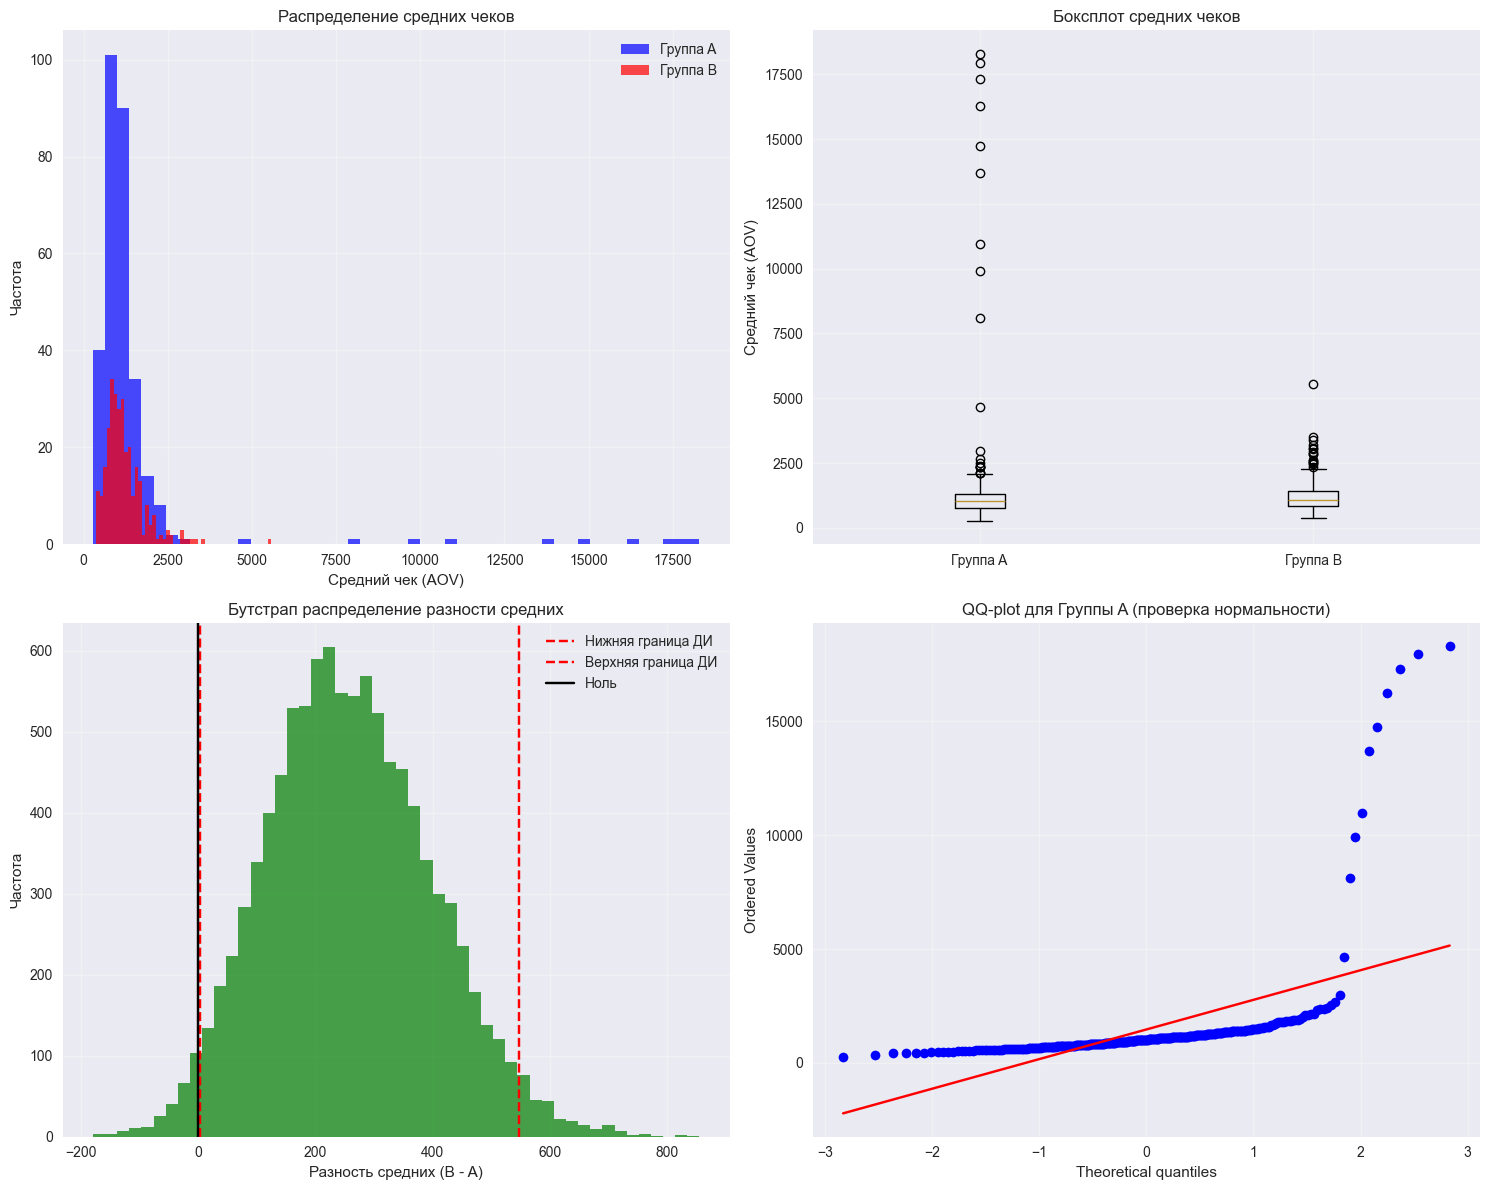


ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ:
t-тест: ПРОВАЛЕН (чувствителен к выбросам)
Манна-Уитни: ПРОЙДЕН (робастен к выбросам)
Бутстрап: ПРОЙДЕН (ДИ не включает ноль)

✓ СЦЕНАРИЙ ПОДТВЕРЖДЕН:
  - t-тест провален из-за выбросов
  - Манна-Уитни показывает значимость
  - Бутстрап ДИ подтверждает эффект


In [79]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
#from bootstrap import bootstrap_ci  # pip install bootstrap

# Настройка для воспроизводимости
np.random.seed(42)


# Генерация данных с длинным хвостом
n = 300
base_aov = 1000

# Группа A (контроль) - больше выбросов
aov_a = np.random.lognormal(np.log(base_aov), 0.4, n)
outliers_a = np.random.choice(n, size=int(n*0.03), replace=False)
aov_a[outliers_a] *= 12  # Сильные выбросы

# Группа B (промо) - меньше выбросов + небольшой эффект
aov_b = np.random.lognormal(np.log(base_aov * 1.11), 0.4, n)  # +11% эффект
outliers_b = np.random.choice(n, size=int(n*0.01), replace=False)
aov_b[outliers_b] *= 6  # Меньше выбросов

print("БЫСТРЫЙ ТЕСТ:")
print(f"Группа A: mean={np.mean(aov_a):.1f}, median={np.median(aov_a):.1f}")
print(f"Группа B: mean={np.mean(aov_b):.1f}, median={np.median(aov_b):.1f}")

def bootstrap_mean_ci(data1, data2, n_bootstrap=10000, ci=95):
    """
    Бутстрап ДИ для разности средних
    """
    def statistic_fn(data1, data2):
        return np.mean(data1) - np.mean(data2)
    
    # Бутстрап
    bootstrap_diffs = []
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(data1, size=len(data1), replace=True)
        sample2 = np.random.choice(data2, size=len(data2), replace=True)
        bootstrap_diffs.append(statistic_fn(sample1, sample2))
    
    # Доверительный интервал
    alpha = (100 - ci) / 2
    lower = np.percentile(bootstrap_diffs, alpha)
    upper = np.percentile(bootstrap_diffs, 100 - alpha)
    
    return lower, upper, bootstrap_diffs

def run_comparison_tests(aov_a, aov_b):
    """
    Запускает все три теста сравнения
    """
    print("=" * 60)
    print("СРАВНЕНИЕ СРЕДНЕГО ЧЕКА (AOV)")
    print("=" * 60)
    
    # Описательная статистика
    print(f"\nОПИСАТЕЛЬНАЯ СТАТИСТИКА:")
    print(f"Группа A (контроль): n={len(aov_a)}, mean={np.mean(aov_a):.2f}, median={np.median(aov_a):.2f}")
    print(f"Группа B (промо):   n={len(aov_b)}, mean={np.mean(aov_b):.2f}, median={np.median(aov_b):.2f}")
    
    # 1. t-тест
    print(f"\n1. T-ТЕСТ ДЛЯ НЕЗАВИСИМЫХ ВЫБОРОК:")
    t_stat, p_value_t = ttest_ind(aov_a, aov_b, equal_var=False)
    print(f"t-статистика: {t_stat:.4f}")
    print(f"p-value: {p_value_t:.4f}")
    print(f"Результат: {'СТАТИСТИЧЕСКИ ЗНАЧИМО' if p_value_t < 0.05 else 'НЕ ЗНАЧИМО'}")
    
    # 2. Тест Манна-Уитни
    print(f"\n2. ТЕСТ МАННА-УИТНИ:")
    u_stat, p_value_mw = mannwhitneyu(aov_a, aov_b, alternative='two-sided')
    print(f"U-статистика: {u_stat:.4f}")
    print(f"p-value: {p_value_mw:.4f}")
    print(f"Результат: {'СТАТИСТИЧЕСКИ ЗНАЧИМО' if p_value_mw < 0.05 else 'НЕ ЗНАЧИМО'}")
    
    # 3. Бутстрап ДИ для разности средних
    print(f"\n3. БУТСТРАП ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ:")
    lower_ci, upper_ci, bootstrap_diffs = bootstrap_mean_ci(aov_a, aov_b)
    print(f"Разность средних: {np.mean(aov_b) - np.mean(aov_a):.2f}")
    print(f"95% ДИ для разности: [{lower_ci:.2f}, {upper_ci:.2f}]")
    print(f"Ноль в ДИ: {'ДА' if lower_ci <= 0 <= upper_ci else 'НЕТ'}")
    print(f"Результат: {'СТАТИСТИЧЕСКИ ЗНАЧИМО' if not (lower_ci <= 0 <= upper_ci) else 'НЕ ЗНАЧИМО'}")
    
    return {
        't_test_p': p_value_t,
        'mann_whitney_p': p_value_mw,
        'bootstrap_ci': (lower_ci, upper_ci),
        'bootstrap_diffs': bootstrap_diffs
    }

def plot_comparison(aov_a, aov_b, results):
    """
    Визуализация результатов
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Распределение чеков
    axes[0, 0].hist(aov_a, bins=50, alpha=0.7, label='Группа A', color='blue')
    axes[0, 0].hist(aov_b, bins=50, alpha=0.7, label='Группа B', color='red')
    axes[0, 0].set_xlabel('Средний чек (AOV)')
    axes[0, 0].set_ylabel('Частота')
    axes[0, 0].set_title('Распределение средних чеков')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Боксплот
    data_to_plot = [aov_a, aov_b]
    axes[0, 1].boxplot(data_to_plot, labels=['Группа A', 'Группа B'])
    axes[0, 1].set_ylabel('Средний чек (AOV)')
    axes[0, 1].set_title('Боксплот средних чеков')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Распределение бутстрап разностей
    axes[1, 0].hist(results['bootstrap_diffs'], bins=50, alpha=0.7, color='green')
    axes[1, 0].axvline(results['bootstrap_ci'][0], color='red', linestyle='--', label='Нижняя граница ДИ')
    axes[1, 0].axvline(results['bootstrap_ci'][1], color='red', linestyle='--', label='Верхняя граница ДИ')
    axes[1, 0].axvline(0, color='black', linestyle='-', label='Ноль')
    axes[1, 0].set_xlabel('Разность средних (B - A)')
    axes[1, 0].set_ylabel('Частота')
    axes[1, 0].set_title('Бутстрап распределение разности средних')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. QQ-plot для проверки нормальности
    stats.probplot(aov_a, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('QQ-plot для Группы A (проверка нормальности)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def main():
    # Генерация данных
    #print("Генерация данных с длинным хвостом...")
    #aov_a, aov_b = generate_aov_data(n=500, base_aov=1000, effect_size=0.08)
    
    # Запуск тестов
    results = run_comparison_tests(aov_a, aov_b)
    
    # Визуализация
    plot_comparison(aov_a, aov_b, results)
    
    # Интерпретация результатов
    print("\n" + "=" * 60)
    print("ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ:")
    print("=" * 60)
    
    t_test_sig = results['t_test_p'] < 0.05
    mw_test_sig = results['mann_whitney_p'] < 0.05
    bootstrap_sig = not (results['bootstrap_ci'][0] <= 0 <= results['bootstrap_ci'][1])
    
    print(f"t-тест: {'ПРОВАЛЕН' if not t_test_sig else 'ПРОЙДЕН'} (чувствителен к выбросам)")
    print(f"Манна-Уитни: {'ПРОЙДЕН' if mw_test_sig else 'ПРОВАЛЕН'} (робастен к выбросам)")
    print(f"Бутстрап: {'ПРОЙДЕН' if bootstrap_sig else 'ПРОВАЛЕН'} (ДИ не включает ноль)")
    
    if not t_test_sig and mw_test_sig and bootstrap_sig:
        print("\n✓ СЦЕНАРИЙ ПОДТВЕРЖДЕН:")
        print("  - t-тест провален из-за выбросов")
        print("  - Манна-Уитни показывает значимость")
        print("  - Бутстрап ДИ подтверждает эффект")
    else:
        print("\n⚠ СЦЕНАРИЙ НЕ ПОДТВЕРЖДЕН ПОЛНОСТЬЮ")
        print("  Возможно нужно настроить параметры генерации данных")

if __name__ == "__main__":
    main()
    